In [28]:
import pandas as pd
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.worksheet.table import Table, TableStyleInfo
import pyxlsb
import numpy as np
import matplotlib.pyplot as plt
import tqdm,os
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
import mlflow
from mlflow.models import infer_signature

In [ ]:
### Trato de predecir el tiempo en el que se van a cerrar los proyectos, por sus caracteristicas
def cleanrows(df):
    if 'STATUSFINAL' in df.columns:
        df = df[df['STATUSFINAL'] == 'PENDIENTE']
    elif 'STATUS FINAL' in df.columns:
        df = df[df['STATUS FINAL'] == 'PENDIENTE']
    return df


def get_date(path):
    timestamp = os.path.getctime(path)
    date_time = datetime.datetime.fromtimestamp(timestamp)
    # Formatear la fecha a DD-MM-YYYY
    formatted_date = date_time.strftime('%d-%m-%Y')
    return formatted_date

def transform_date(df):
    df['FECH_CONTAB'] = pd.to_datetime(df['FECH_CONTAB'])
    df[['year', 'month', 'day']] = df['FECH_CONTAB'].apply(lambda x: pd.Series([x.year, x.month, x.day]))
    df.drop(columns=['FECH_CONTAB'],inplace=True)
    return df
def transform_data(df):
    df['TEXTO_BREVE'] = df['TEXTO_BREVE'].astype('category')
    df['NOMPROVEEDOR'] = df['NOMPROVEEDOR'].astype('category')    
    # Transformaciones en df_norma
    df['RESPONSABLE3'] = (df['RESPONSABLE3']
                                .str.upper()
                                .replace({'JENNY PIZAN': 'JENNY', 'MARLON': 'FERNANDO', '0': pd.NA, 'EDWIN': 'FERNANDO'})
                                .dropna())
    df['RESPONSABLE3'] = df['RESPONSABLE3'].astype('category')   
    return df

def transformar_datos(df):
    # Transformaciones en df
    #df['Time2Close'] = df['Time2Close'].str.replace('days', '').astype(int)
    df['FECH_CONTAB'] = pd.to_datetime(df['FECH_CONTAB'])
    df['TEXTO_BREVE'] = df['TEXTO_BREVE'].astype('category')
    df['NOMPROVEEDOR'] = df['NOMPROVEEDOR'].astype('category')    
    # Transformaciones en df_norma
    df['RESPONSABLE3'] = (df['RESPONSABLE3']
                                .str.upper()
                                .replace({'JENNY PIZAN': 'JENNY', 'MARLON': 'FERNANDO', '0': pd.NA, 'EDWIN': 'FERNANDO'})
                                .dropna())
    df['RESPONSABLE3'] = df['RESPONSABLE3'].astype('category')
    df[['year', 'month', 'day']] = df['FECH_CONTAB'].apply(lambda x: p.Series([x.year, x.month, x.day]))
    df = df[~df.RESPONSABLE3.isna()]
    df = df.drop(columns=['FECH_CONTAB','CONCA'])  # escalar dimensiones numericas
    return df



## Cargo la info 

In [ ]:
# Ruta al directorio que contiene los archivos
directorio = r'\\LIMBIPBICOV01.claro.pe\Red Región Norte\Resultados_prepa'
# Dicc para almacenar los DataFrames
dfs = []
# Itera sobre todos los archivos en el directorio

for filename in tqdm.tqdm(os.listdir(directorio)):
    file_path = os.path.join(directorio, filename)
    # Verifica si el path es un archivo y no un directorio<
    if os.path.isfile(file_path):
        df = pd.read_excel(file_path,sheet_name='Sheet1')
        df =  df[df.RESPONSABLE2 == 'Eduardo Iberico']
        df = cleanrows(df)
        # Obtiene el nombre del archivo sin la extensión
        Time = get_date(file_path)
        # Añade el DataFrame al diccionario
        df['TIME'] = Time
        df['TIME'] =  pd.to_datetime(df['TIME'],format = '%d-%m-%Y')
        dfs.append(df)
        # Añade el DataFrame al diccionario
        dfs.append(df)
# Etiqueto cada Df por su temporalidad, añado una columna mas con dicha etiqueta         
    
# Combina todos los dataframes en uno solo
#df_combinado = pd.concat(dfs.values())
#df_combinado = date_format(df_combinado)

##Cuidado con los archivos temporales en la carpeta 

df_combinado_prepa = pd.concat(dfs,ignore_index=True)

df_combinado_prepa_cut = df_combinado_prepa[['CONCA','TEXTO_BREVE','DEMORA','NOMPROVEEDOR','FECH_CONTAB','ESTADO','TIME','RESPONSABLE3']]## DIMENSIONES 


df_combinado_prepa_clean = df_combinado_prepa_cut[~df_combinado_prepa_cut.RESPONSABLE3.isna()].query("`ESTADO` == 'Finalizado'")

df_combinado_cut_clean = df_combinado_prepa_clean.sort_values(by='TIME')

df_combinado_final = df_combinado_cut_clean[~df_combinado_cut_clean.FECH_CONTAB.isna()]\
                        .drop_duplicates(subset=['CONCA', 'DOCUMENTO_REFERENCIA'], keep='first')\
                        .assign(FECH_CONTAB=lambda x: pd.to_datetime(x['FECH_CONTAB'], format='%d-%m-%Y')).copy()\
                        .assign(Time2Close=lambda x: x['TIME']- x['FECH_CONTAB'])\
                        .groupby(['CONCA','TEXTO_BREVE','NOMPROVEEDOR','FECH_CONTAB','RESPONSABLE3'])['Time2Close'].mean().to_frame().reset_index()



In [26]:
print(df_combinado_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   CONCA         1567 non-null   int64          
 1   TEXTO_BREVE   1567 non-null   object         
 2   NOMPROVEEDOR  1567 non-null   object         
 3   FECH_CONTAB   1567 non-null   datetime64[ns] 
 4   RESPONSABLE3  1567 non-null   object         
 5   Time2Close    1567 non-null   timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(3), timedelta64[ns](1)
memory usage: 73.6+ KB
None


## Cargo Dataset

In [27]:
df_combinado_final

,CONCA,TEXTO_BREVE,NOMPROVEEDOR,FECH_CONTAB,RESPONSABLE3,Time2Close
0,450060993310,HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,HUAWEI DEL PERU SAC,2023-11-13,JENNY,151 days
1,450060993330,HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,HUAWEI DEL PERU SAC,2023-11-13,JENNY,151 days
2,450061238810,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,2023-10-13,JENNY,180 days
3,450061238820,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,2023-10-13,JENNY,180 days
4,450061238830,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,2023-11-02,JENNY,160 days
...,...,...,...,...,...,...
1562,45007228433610,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,2024-09-05,ANGGIE,41 days
1563,45007228433670,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,2024-09-05,ANGGIE,41 days
1564,45007228433700,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,2024-09-04,ANGGIE,42 days
1565,45007228433770,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,2024-09-05,ANGGIE,62 days


In [9]:
df_final = pd.read_csv('dataset_prepa.csv')

In [10]:
df_final## la fecha en formato de segundos luego de la fecha ese, a modo de que sea un maginitud
#Txto_breve y el Nomvproveedor van en el onehot encoder ? 
## el analista tmb es un dimension relevante 
#  

,CONCA,TEXTO_BREVE,NOMPROVEEDOR,RESPONSABLE3,FECH_CONTAB,Time2Close
0,450060993310,HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,HUAWEI DEL PERU SAC,JENNY,2023-11-13,151 days
1,450060993330,HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,HUAWEI DEL PERU SAC,JENNY,2023-11-13,151 days
2,450061238810,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,JENNY,2023-10-13,180 days
3,450061238820,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,JENNY,2023-10-13,180 days
4,450061238830,INSTALACIÓN DE ROUTER,HUAWEI DEL PERU SAC,JENNY,2023-11-02,160 days
...,...,...,...,...,...,...
1409,45007049161220,IMPLEMENTACIÓN DE ENODO B LTE,TELRAD PERU S.A.,ANGGIE,2024-07-03,50 days
1410,45007049161230,IMPLEMENTACIÓN DE ENODO B LTE,TELRAD PERU S.A.,ANGGIE,2024-07-02,51 days
1411,45007049161260,IMPLEMENTACIÓN DE ENODO B LTE,TELRAD PERU S.A.,ANGGIE,2024-06-24,38 days
1412,45007049161300,IMPLEMENTACIÓN DE ENODO B LTE,TELRAD PERU S.A.,ANGGIE,2024-07-02,51 days


In [106]:

# Aplicar la función a tus DataFrames
df_final_norma = transformar_datos(df_final)


In [ ]:
cx_df = df_final_norma.drop(columns=['Time2Close'])

y = df_final_norma.Time2Close

In [13]:
df_final_norma[['TEXTO_BREVE','NOMPROVEEDOR','RESPONSABLE3']].describe()

,TEXTO_BREVE,NOMPROVEEDOR,RESPONSABLE3
count,1368,1368,1368
unique,29,24,8
top,IMPLEMENTACIÓN DE ENODO B LTE,CJ TELECOM S.A.C.,ANGGIE
freq,446,398,536


C:\Users\C26764\AppData\Local\Temp\ipykernel_21588\1970117671.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="RESPONSABLE3", y="Time2Close",
C:\Users\C26764\AppData\Local\Temp\ipykernel_21588\1970117671.py:7: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="RESPONSABLE3", y="Time2Close",


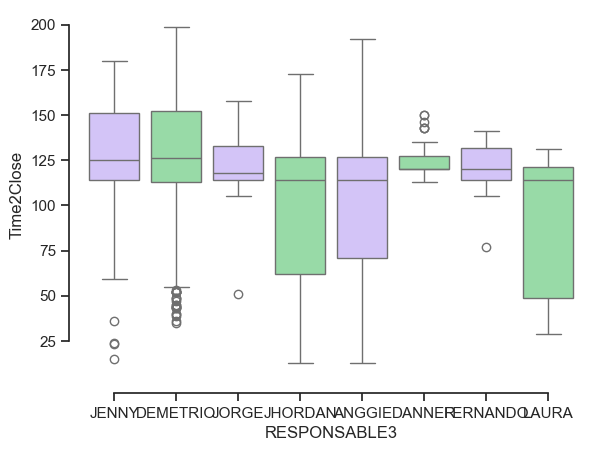

In [56]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="RESPONSABLE3", y="Time2Close",
             palette=["m", "g"],
            data=df_final_norma)
sns.despine(offset=10, trim=True)

## Divido el dataset 

In [17]:
from sklearn.model_selection import train_test_split

# Divide el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.2, random_state=42)


## Transformo las dimenciones del dataset para que se pueda pasar al SVR(uso un pipeline)
- Lo que hace es hacer un trensito de todo los procesos, donde la cabeza es el modelo de ML

In [18]:
# Definir el preprocesador
columns_to_encode = ['RESPONSABLE3','NOMPROVEEDOR','TEXTO_BREVE']
numeric_features = ['year','month','day']
# Seleccionar columnas numéricas
numeric_features = df_final_norma.select_dtypes(include=['int64','int32']).columns



In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['year','month','day']),
        ('cat', OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore'), columns_to_encode)
    ])
# Crear el pipeline
pipeline = make_pipeline(preprocessor, SVR())

In [20]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['RESPONSABLE3',
                                                   'NOMPROVEEDOR',
                                                   'TEXTO_BREVE'])])),
                ('svr', SVR())])

In [67]:
param_grid = {
    'svr__C': [10, 100,200,400],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale', 'auto']}

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094 entries, 257 to 1170
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TEXTO_BREVE   1094 non-null   category
 1   NOMPROVEEDOR  1094 non-null   category
 2   RESPONSABLE3  1094 non-null   category
 3   year          1094 non-null   int64   
 4   month         1094 non-null   int64   
 5   day           1094 non-null   int64   
dtypes: category(3), int64(3)
memory usage: 39.8 KB


In [69]:
# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='neg_mean_squared_error') ## pao el pipeline que finalmente tiene el modelo
grid_search.fit(X_train, y_train)



C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded 

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'month',
                                                                          'day']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['RESPONSABLE3',
                                                                          'NOMPROVEEDOR',
                                                                          'TEXTO_BREVE'])])),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [10, 100, 200, 400],
                         'svr__epsilon': [0.01, 0.1, 0.5, 1],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [70]:
# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Predecir con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros: {'svr__C': 400, 'svr__epsilon': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
best_model.score(X_test,y_test)

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8781817338556691

In [81]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['RESPONSABLE3',
                                                   'NOMPROVEEDOR',
                                                   'TEXTO_BREVE'])])),
                ('svr', SVR(C=400, epsilon=1, gamma='auto'))])

In [72]:
y_pred

array([125.66427223, 119.00013383,  78.832137  , 133.28434514,
       137.68114605, 118.99953051, 173.90943863,  72.25377084,
       131.96061711, 116.01785871, 132.61582039, 120.0467715 ,
       114.60550469,  24.3806223 , 118.2809141 , 169.16828587,
        77.49945028, 117.79786536, 136.99926644,  61.99935432,
       123.6008299 , 123.24674102, 120.0467715 , 178.79252305,
        49.15549529, 137.07461488,  60.0007268 , 119.00013383,
       137.07461488, 131.61167762, 129.6912223 ,  69.97578299,
        51.00015753,  48.06586493, 150.37422136, 125.76045759,
        47.41878501, 152.78257715,  52.9999252 , 153.00003368,
       150.93130931, 120.00048191,  54.11155189,  73.99989663,
        60.58261209, 123.89667064,  54.34192908, 114.94811702,
       114.60550469, 122.4132725 , 123.21536555, 126.97124648,
       115.41257837, 140.27671987,  30.00003923, 121.79433394,
       132.00033599,  30.00003923,  62.72495092,  56.71636218,
       124.08541638,  55.1370601 , 120.00048191,  49.28

## Metricas del modelo

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [74]:
y_true = y_test

MAE: 9.179212563351781
MSE: 194.95416047374923
RMSE: 13.962598628971229
R²: 0.8781817338556691


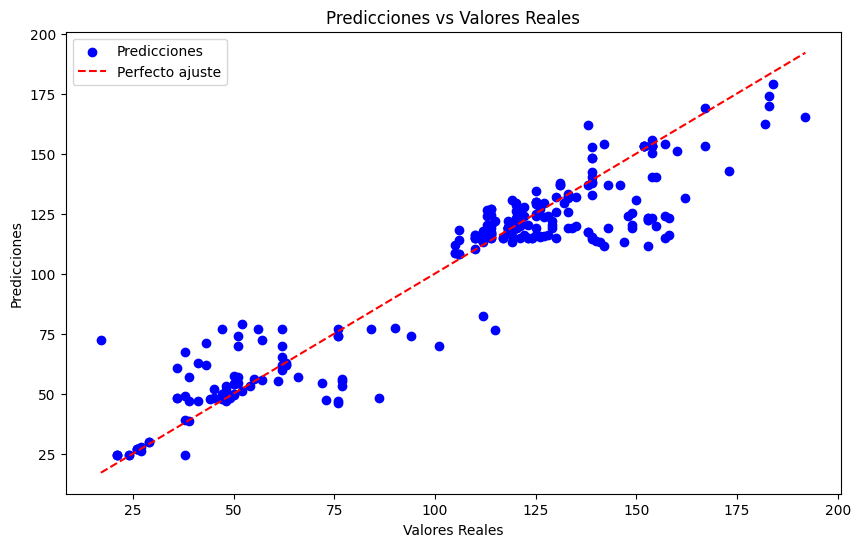

In [75]:
# Calcula las métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Imprime las métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Visualiza las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', label='Predicciones')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfecto ajuste')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.show()

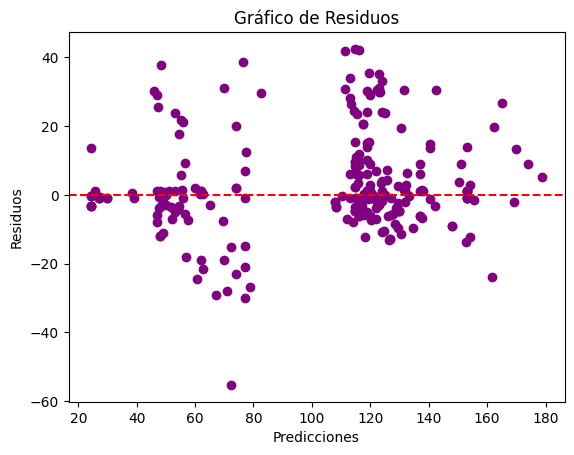

In [78]:
residuals = y_true - y_pred
plt.scatter(y_pred, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()


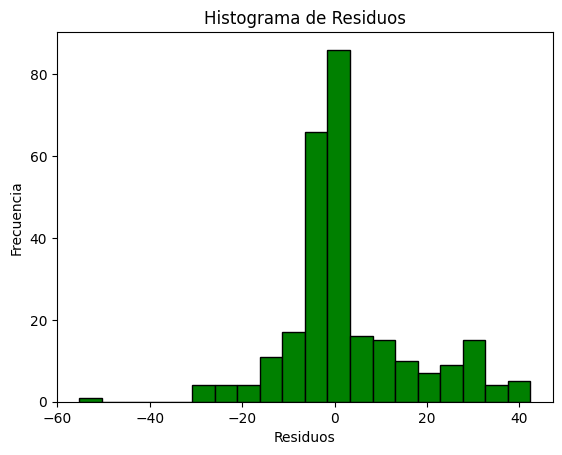

In [79]:
plt.hist(residuals, bins=20, color='green', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()


In [99]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 446 to 552
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TEXTO_BREVE   274 non-null    category
 1   NOMPROVEEDOR  274 non-null    category
 2   RESPONSABLE3  274 non-null    category
 3   year          274 non-null    int64   
 4   month         274 non-null    int64   
 5   day           274 non-null    int64   
dtypes: category(3), int64(3)
memory usage: 11.7 KB


## Cargo data para pruebas reales

In [ ]:
df_real = pd.read_excel(r'Z:\Resultados_prepa\PREPA_UPDATE16.10.xlsx',sheet_name='Sheet1')
#Proyectado - demora = RESTANTE 
#Restante + Fecha actual =  fecha posible de cierre 

df_real = df_real[(df_real.RESPONSABLE2 == 'Eduardo Iberico') & (df_real_cut['MES-COMPROMISO'] == 'NUEVAS EA')]

df_real_cut = df_real[['CONCA','TEXTO_BREVE','FECH_CONTAB','NOMPROVEEDOR','DEMORA','RESPONSABLE3','SITE','ESTADO']]

df_real4ML = df_real_cut[['CONCA','TEXTO_BREVE','FECH_CONTAB','NOMPROVEEDOR','RESPONSABLE3']]

df_final = transformar_datos(df_real4ML)

In [113]:
resultado = best_model.predict(df_final)

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
df_resultado = pd.DataFrame(resultado,columns = ['Time2Close'])

df_resultado.Time2Close = df_resultado.Time2Close.round()

df_resultado

In [ ]:
df_real_cut = df_real_cut.reset_index(drop=True)

DF_Predict = pd.concat([df_real_cut,df_resultado],axis=1)

DF_Predict.head(50)

In [83]:
#Formato
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 446 to 552
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TEXTO_BREVE   274 non-null    category
 1   NOMPROVEEDOR  274 non-null    category
 2   RESPONSABLE3  274 non-null    category
 3   year          274 non-null    int64   
 4   month         274 non-null    int64   
 5   day           274 non-null    int64   
dtypes: category(3), int64(3)
memory usage: 11.7 KB


In [17]:
columnas_a_escalar = ['year', 'month', 'day']
columns_to_encode = ['TEXTO_BREVE','NOMPROVEEDOR','RESPONSABLE3']

In [18]:
scaler = StandardScaler()
df_final_norma[columnas_a_escalar] = scaler.fit_transform(df_final_norma[columnas_a_escalar])

In [19]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Aplica el codificador a las columnas seleccionadas
encoded_data = encoder.fit_transform(df_final_norma[columns_to_encode])
# Convierte el resultado en un DataFrame y utiliza get_feature_names_out para obtener los nombres de las columnas
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Asegúrate de mantener el índice original
df_encoded.index = df_final_norma.index

In [20]:
x_df = pd.concat([df_encoded,df_final_norma[['year', 'month', 'day']]],axis=1)

In [67]:
x_df


,TEXTO_BREVE_DISENO DE PROYECTOS,TEXTO_BREVE_HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,TEXTO_BREVE_IMPLEMENTACION CELL SITE ROUTER,TEXTO_BREVE_IMPLEMENTACION EQUIPO DWDM,TEXTO_BREVE_IMPLEMENTACION LAMBDAS 100G,TEXTO_BREVE_IMPLEMENTACION LINEA ELECTRICA BT,TEXTO_BREVE_IMPLEMENTACION LINEA ELECTRICA MT,TEXTO_BREVE_IMPLEMENTACION PANEL SOLAR,TEXTO_BREVE_IMPLEMENTACION PLANTA EXTERNA FO,TEXTO_BREVE_IMPLEMENTACIÓN DE ENODO B LTE,...,RESPONSABLE3_JHORDAN,RESPONSABLE3_JORGE,RESPONSABLE3_Jenny,RESPONSABLE3_Jenny Pizan,RESPONSABLE3_LAURA,RESPONSABLE3_MARLON,RESPONSABLE3_Marlon,year,month,day
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.617138,0.285329,-0.498107
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.617138,0.285329,-0.498107
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.617138,-0.094930,-0.498107
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.617138,-0.094930,-0.498107
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.617138,0.285329,-1.965724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.620383,-1.235709,-1.832304
1410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.620383,-1.235709,-1.965724
1411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.620383,-1.615969,0.969511
1412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.620383,-1.235709,-1.965724


In [66]:
y = df_final_norma['Time2Close']

In [72]:
model = SVR()
# Definir el rango de hiperparámetros para la búsqueda en cuadrícula

}

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search.fit(x_df, y)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Predecir con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_df)




Mejores hiperparámetros: {'C': 100, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# Escalar las características numericas
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Para las columnas categoricas 
# ONE HOT ENCODER AQUI 

In [ ]:
# de aqui solo me interasa sacar el tiempo de cierre que luego voy a trasladar al df de EAS, dropear unicos por CONCA, calcular timepo de cierre me falta la fecha doc 

In [5]:
# Ruta al directorio que contiene los archivos
directorio = r'D:\EA\Resultados'
# Dicc para almacenar los DataFrames
dfs = []
# Itera sobre todos los archivos en el directorio

for filename in tqdm.tqdm(os.listdir(directorio)):
    file_path = os.path.join(directorio, filename)
    # Verifica si el path es un archivo y no un directorio<
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        #df =  df[df.RESPONSABLE2 == 'Eduardo Iberico']
        #df = cleanrows(df)
        # Obtiene el nombre del archivo sin la extensión
        Time = get_date(file_path)
        # Añade el DataFrame al diccionario
        df['TIME'] = Time
        df['TIME'] =  pd.to_datetime(df['TIME'],format = '%d-%m-%Y')
        dfs.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 42.15it/s]


In [8]:
df_combinado = pd.concat(dfs,ignore_index=True)

In [10]:
df_combinado = df_combinado.drop_duplicates(subset='CONCATENADO')

In [11]:
df_combinado

,CONCATENADO,NUMERO OC,POS_PREC,FECHA_DOC,Estrategia de Liberación,Cod.Solicitante,SOLICITANTE,TIPO_DOC,TIPO DE MATERIAL,MATERIAL,...,ESTATUS GENERAL,OT,Estado de EA,Fecha de Ejecucion,TIME,ESTATUS_GENERAL,RESPONSABLE DE EA,ESTATUS GENERAL_x,ESTATUS GENERAL_y,MES_DOC
0,450068193770,4500681937,70,2024-01-08,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000752.0,...,ON AIR,20590,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN
1,450068202310,4500682023,10,2024-01-08,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000752.0,...,CW/TI,30422,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN
2,450068317770,4500683177,70,2024-01-12,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3009529.0,...,TI,22920,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN
3,450068317780,4500683177,80,2024-01-12,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3006091.0,...,TI,22920,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN
4,450068317790,4500683177,90,2024-01-12,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000752.0,...,TI,22920,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49477,450074659430,4500746594,30,2024-09-25,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000719.0,...,NaN,NaN,PENDIENTE,NaN,2024-09-30,NaN,NaN,NaN,NaN,NaN
49478,450074659420,4500746594,20,2024-09-25,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3030623.0,...,NaN,24899,PENDIENTE,NaN,2024-09-30,ING,NaN,NaN,NaN,NaN
49479,450074659410,4500746594,10,2024-09-25,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3030623.0,...,NaN,NaN,PENDIENTE,NaN,2024-09-30,NaN,NaN,NaN,NaN,NaN
49480,200072466220,2000724662,20,2024-09-25,NaN,PREDESGT027U,Eduardo Iberico,Solicitudes de pedidos,SERVICIO,3028431.0,...,NaN,NaN,PENDIENTE,NaN,2024-09-30,NaN,NaN,NaN,NaN,NaN


In [29]:
df_final.rename(columns={'CONCA':'CONCATENADO'},inplace=True)

In [30]:
df_merged =  pd.merge(df_combinado,df_final,on='CONCATENADO',how='left')

In [33]:
df_merged[~df_merged.Time2Close.isna()]

,CONCATENADO,NUMERO OC,POS_PREC,FECHA_DOC,Estrategia de Liberación,Cod.Solicitante,SOLICITANTE,TIPO_DOC,TIPO DE MATERIAL,MATERIAL,...,OT,Estado de EA,Fecha de Ejecucion,TIME,ESTATUS_GENERAL,RESPONSABLE DE EA,ESTATUS GENERAL_x,ESTATUS GENERAL_y,MES_DOC,Time2Close
6,450068182750,4500681827,50,2024-01-04,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3009529.0,...,24018,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN,48 days
7,450068182760,4500681827,60,2024-01-04,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3006091.0,...,24018,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN,48 days
9,450068182780,4500681827,80,2024-01-04,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000731.0,...,24018,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN,48 days
12,450068740520,4500687405,20,2024-01-26,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3006091.0,...,24019,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN,56 days
14,450068740540,4500687405,40,2024-01-26,Sin Pendientes Lib,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000731.0,...,24019,PENDIENTE,NaN,2024-07-01,NaN,NaN,NaN,NaN,NaN,47 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,450071045540,4500710455,40,2024-04-30,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000732.0,...,NaN,PENDIENTE,NaN,2024-06-13,NaN,ANNGIE,NaN,NaN,abril,94 days
1717,450071045530,4500710455,30,2024-04-30,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000732.0,...,NaN,PENDIENTE,NaN,2024-06-13,NaN,ANNGIE,NaN,NaN,abril,85 days
1718,450071045520,4500710455,20,2024-04-30,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000732.0,...,NaN,PENDIENTE,NaN,2024-06-13,NaN,ANNGIE,NaN,NaN,abril,76 days
1719,450071045510,4500710455,10,2024-04-30,Pendiente de Liberación,PREDESGT027U,Eduardo Iberico,Pedidos,SERVICIO,3000732.0,...,NaN,PENDIENTE,NaN,2024-06-13,NaN,ANNGIE,NaN,NaN,abril,76 days


In [32]:
df_merged.info() # de estos 210 tienen que salir laa dimensiones, tengo que transformar el resultado de los prepa a formato eas, missin columns y sus respectivos valores.????? como ???? 

# En el peor de los casos tendre que hacerlo con la data del prepa only 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2245 entries, 0 to 2244
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   CONCATENADO               2245 non-null   int64          
 1   NUMERO OC                 2245 non-null   int64          
 2   POS_PREC                  2245 non-null   int64          
 3   FECHA_DOC                 2245 non-null   object         
 4   Estrategia de Liberación  1837 non-null   object         
 5   Cod.Solicitante           2245 non-null   object         
 6   SOLICITANTE               2245 non-null   object         
 7   TIPO_DOC                  2245 non-null   object         
 8   TIPO DE MATERIAL          2245 non-null   object         
 9   MATERIAL                  2245 non-null   float64        
 10  TEXTO                     2245 non-null   object         
 11  COD_PROVEEDOR             1837 non-null   float64        
 12  PROVEE

In [19]:
formatted_date

'27-09-2024'

In [11]:
df_combinado.columns

Index(['DOC_COMPRAS', 'POSIC', 'CONCA', 'DOCUMENTO_REFERENCIA', 'FONDO',
       'TEXTO_BREVE', 'CODPROVEEDOR', 'NOMPROVEEDOR', 'FECH_CONTAB', 'MON',
       ...
       'fcst', 'ANTIGUAMIENTO_PAP.1', 'DÍAS-2.1', 'DÍAS-2.2', 'ESTADO.1',
       'COMENTARIO.1', 'AVANCE18.09', 'EstadoTec.', 'PAP.1', 'DÍAS -2'],
      dtype='object', length=134)

In [ ]:
#Ingiero el grande sin proceso
df_Timed_ended = df_2_recort[df_2_recort.ESTADO =='Finalizado'] #2662
df_finalizados = df_Timed_ended.sort_values('TIME').drop_duplicates('PAP', keep='first')


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supongamos que X son tus características y y es el tiempo en días
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Predicciones
y_pred = svr.predict(X_test_scaled)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Supongamos que X son tus características y y es el tiempo en días
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
